# Abstract Meaning Representation(AMR) to text with TensorFlow 

AMR is a graph-based representation that aims to preserve semantic relations. AMR graphs are rooted, labelled, directed, acyclic graphs, comprising whole sentences. They are intended to abstract away from syntactic representations. In this sense, sentences similar in meaning should be assigned the same AMR, even if they are not identically worded.

Example:

”China is expanding its military power to attempt to join the ranks of the superpowers” 

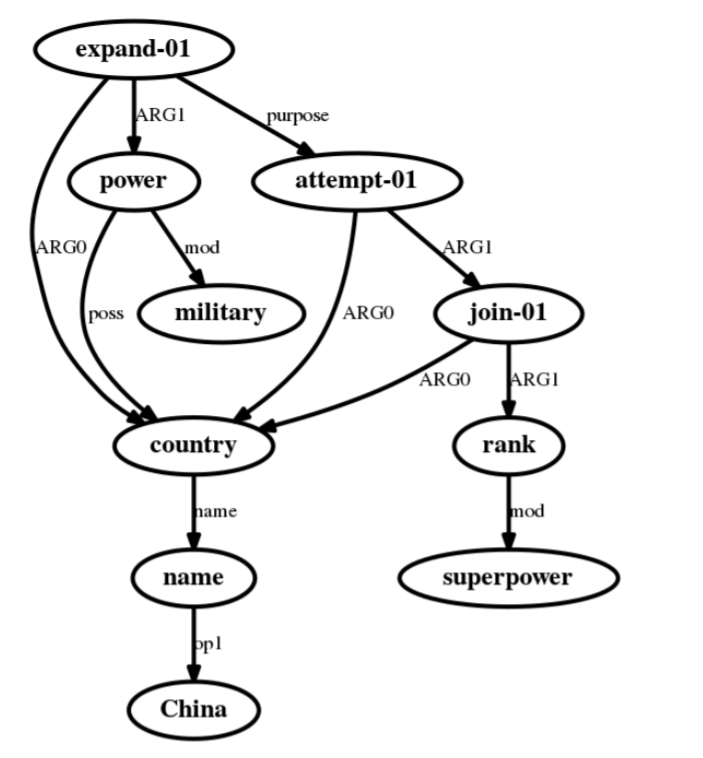

To read about it more, please refer [this](https://analyticsindiamag.com/guide-to-abstract-meaning-representationamr-to-text-with-tensorflow/) article.

In [ ]:
!python -m pip install pip --upgrade --user -q --no-warn-script-location
!python -m pip install numpy pandas seaborn matplotlib scipy statsmodels sklearn nltk gensim --user -q --no-warn-script-location

import IPython
IPython.Application.instance().kernel.do_shutdown(True)


In [1]:
import json 
import sys
import re
from collections import Counter
import codecs

Data Source


In [3]:
!wget https://amr.isi.edu/download/amr-bank-struct-v1.6.txt

--2021-06-18 06:27:27--  https://amr.isi.edu/download/amr-bank-struct-v1.6.txt
Resolving amr.isi.edu (amr.isi.edu)... 128.9.47.110
Connecting to amr.isi.edu (amr.isi.edu)|128.9.47.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 776402 (758K) [text/plain]
Saving to: ‘amr-bank-struct-v1.6.txt’

amr-bank-struct-v1. 100%[===================>] 758.21K  1.32MB/s    in 0.6s    

2021-06-18 06:27:28 (1.32 MB/s) - ‘amr-bank-struct-v1.6.txt’ saved [776402/776402]



# Data Prep

Converting Multiline AMR to Singleline AMR<br>


In [4]:


ids = []
sentences=[]
id_dict = {}
amrs = []
amr_str = ''
for line in open('amr-bank-struct-v1.6.txt','rU'):
    if line.startswith('#'):
        if line.startswith('# ::id'):
            id = line.lower().strip().split()[2]
            ids.append(id)
            id_dict[id] = len(ids)-1
            continue
        if line.startswith('# ::snt'):
            snt = line.lower().strip().split()[2:]
            sentences.append(' '.join(snt))
            continue
    line = line.strip()
    if line == '':
        if amr_str != '':
            amrs.append(amr_str.strip())
            amr_str = ''
    else:
        amr_str = amr_str + line + ' '

if amr_str != '':
    amrs.append(amr_str.strip())
    amr_str = ''
with open('demo.amr','w',encoding="utf-8") as f:
  [f.write(i+'\n') for i in amrs]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: 'U' mode is deprecated
  


Simplified the Single line AMRs using [application](https://drive.google.com/file/d/1PE8b44-H3Hu4I2Xf1XDAPFhH-GonR43i/view?usp=sharing).<br>
Command-    ./anonDeAnon_java.sh anonymizeAmrFull true demo.amr
<br> demo.amr.anonymized is the output file

In [9]:
!gdown https://drive.google.com/uc?id=1PE8b44-H3Hu4I2Xf1XDAPFhH-GonR43i

Downloading...
From: https://drive.google.com/uc?id=1PE8b44-H3Hu4I2Xf1XDAPFhH-GonR43i
To: /content/amr_simplifier.zip
322MB [00:02, 158MB/s]


In [10]:
!unzip amr_simplifier

Archive:  amr_simplifier.zip
   creating: NeuralAmr_NoAnon/
   creating: NeuralAmr_NoAnon/.git/
   creating: NeuralAmr_NoAnon/.git/refs/
   creating: NeuralAmr_NoAnon/.git/refs/heads/
  inflating: NeuralAmr_NoAnon/.git/refs/heads/master  
   creating: NeuralAmr_NoAnon/.git/refs/tags/
   creating: NeuralAmr_NoAnon/.git/refs/remotes/
   creating: NeuralAmr_NoAnon/.git/refs/remotes/origin/
  inflating: NeuralAmr_NoAnon/.git/refs/remotes/origin/HEAD  
   creating: NeuralAmr_NoAnon/.git/branches/
  inflating: NeuralAmr_NoAnon/.git/description  
   creating: NeuralAmr_NoAnon/.git/hooks/
  inflating: NeuralAmr_NoAnon/.git/hooks/applypatch-msg.sample  
  inflating: NeuralAmr_NoAnon/.git/hooks/commit-msg.sample  
  inflating: NeuralAmr_NoAnon/.git/hooks/post-update.sample  
  inflating: NeuralAmr_NoAnon/.git/hooks/pre-applypatch.sample  
  inflating: NeuralAmr_NoAnon/.git/hooks/pre-commit.sample  
  inflating: NeuralAmr_NoAnon/.git/hooks/pre-push.sample  
  inflating: NeuralAmr_NoAnon/.git/hook

In [15]:
%%bash
./NeuralAmr_NoAnon/anonDeAnon_java.shanonymizeAmrFull true demo.amr

bash: line 1: ./NeuralAmr_NoAnon/anonDeAnon_java.shanonymizeAmrFull: No such file or directory


In [16]:
with open('NeuralAmr_NoAnon/demo.amr.anonymized','r',encoding="utf-8") as f:
  print(f.readlines()[1])

IndexError: ignored

In [ ]:
len(ids),len(amrs),len(sentences)

(1562, 1563, 1562)

Making json input

In [ ]:
ld=[]
for i,j,k in zip(amrs,sentences,ids):
  ld.append({"amr":i,
    "sent":j,
    "id":k})
with open("data.json", "w", encoding='utf-8') as write_file:
    json.dump(ld, write_file, ensure_ascii=False)

Extracting Vocabulary

In [ ]:



def update(l, v):
    v.update([x.lower() for x in l])

def update_vocab(path, vocab, vocab_edge, vocab_node):
    words = []
    words_edge = []
    words_node = []
    data = json.load(open(path,'rU'))
    for inst in data:
        words += inst['sent'].lower().strip().split()
        words += [x for x in inst['amr'].lower().strip().split() if x[0] != ':']
        words_edge += [x for x in inst['amr'].lower().strip().split() if x[0] == ':']
        words_node += [x for x in inst['amr'].lower().strip().split() if re.search('_[0-9]+', x) != None or x == 'num_unk']
    update(words, vocab)
    update(words_edge, vocab_edge)
    update(words_node, vocab_node)

def output(d, path):
    original_stdout = sys.stdout
    f = codecs.open(path,'w',encoding='utf-8')
    sys.stdout = f
    for k,v in sorted(d.items(), key=lambda x:-x[1]):
        print(k)
    sys.stdout = original_stdout
    f.close()

##################

vocab = Counter()
vocab_edge = Counter()
vocab_node = Counter()
update_vocab('data.json', vocab, vocab_edge, vocab_node)
print(len(vocab), len(vocab_edge), len(vocab_node))

output(vocab, 'vocab.txt')
output(vocab_edge, 'vocab_edge.txt')
output(vocab_node, 'vocab_node.txt')

7937 77 1561


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: 'U' mode is deprecated
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
import json
js=json.load(open('data.json','r'))
js[10]

{'amr': '# ::zh 它是这样的：我把我的这副杰作拿给大人看，我问他们我的画是不是叫他们害怕。 # ::save-date Thu Oct 29, 2015 ::file lpp_1943_10.txt (a / and :op1 (l / look-02 :ARG0 (i / it) :ARG1 (t / this)) :op2 (s / show-01 :ARG0 (i2 / i) :ARG1 (m / masterpiece :poss i2) :ARG2 (g / grown-up)) :op3 (a2 / ask-01 :ARG0 i2 :ARG1 (f / frighten-01 :mode interrogative :ARG0 (p / picture :ARG1-of (d / draw-01)) :ARG1 g) :ARG2 g))',
 'id': 'lpp_1943.11',
 'sent': 'but they answered : " frighten ?'}

In [ ]:
import G2S_data_stream
import importlib
importlib.reload(G2S_data_stream)
trainset, trn_node, trn_in_neigh, trn_out_neigh, trn_sent = G2S_data_stream.read_amr_file('data.json')
print('Number of training samples: {}'.format(len(trainset[0])))

['lpp_1943.1', 'lpp_1943.2', 'lpp_1943.3', 'lpp_1943.4', 'lpp_1943.5', 'lpp_1943.6', 'lpp_1943.7', 'lpp_1943.8', 'lpp_1943.9', 'lpp_1943.10', 'lpp_1943.11', 'lpp_1943.12', 'lpp_1943.13', 'lpp_1943.14', 'lpp_1943.15', 'lpp_1943.16', 'lpp_1943.17', 'lpp_1943.18', 'lpp_1943.19', 'lpp_1943.20', 'lpp_1943.21', 'lpp_1943.22', 'lpp_1943.23', 'lpp_1943.24', 'lpp_1943.25', 'lpp_1943.26', 'lpp_1943.27', 'lpp_1943.28', 'lpp_1943.29', 'lpp_1943.30', 'lpp_1943.31', 'lpp_1943.32', 'lpp_1943.33', 'lpp_1943.34', 'lpp_1943.35', 'lpp_1943.36', 'lpp_1943.37', 'lpp_1943.38', 'lpp_1943.39', 'lpp_1943.40', 'lpp_1943.41', 'lpp_1943.42', 'lpp_1943.43', 'lpp_1943.44', 'lpp_1943.45', 'lpp_1943.46', 'lpp_1943.47', 'lpp_1943.48', 'lpp_1943.49', 'lpp_1943.50', 'lpp_1943.51', 'lpp_1943.52', 'lpp_1943.53', 'lpp_1943.54', 'lpp_1943.55', 'lpp_1943.56', 'lpp_1943.57', 'lpp_1943.58', 'lpp_1943.59', 'lpp_1943.60', 'lpp_1943.61', 'lpp_1943.62', 'lpp_1943.63', 'lpp_1943.64', 'lpp_1943.65', 'lpp_1943.66', 'lpp_1943.67', 'lp

In [ ]:
word_vocab = None
char_vocab = None
edgelabel_vocab = None

(allWords, allChars, allEdgelabels) = G2S_data_stream.collect_vocabs(trainset)
print('Number of words: {}'.format(len(allWords)))
print('Number of allChars: {}'.format(len(allChars)))
print('Number of allEdgelabels: {}'.format(len(allEdgelabels)))

7
Number of words: 7944
Number of allChars: 1537
Number of allEdgelabels: 78


In [ ]:

import numpy
import sys, os
from collections import Counter

original_stdout=sys.stdout

vocab = set(line.strip() for line in open('vocab.txt', 'r',encoding='utf8'))
print('len(vocab)', len(vocab))

intersect = set()
f = open('word_embeddings.txt', 'w',encoding='utf8')
sys.stdout=f
for line in open('glove.6B.300d.txt', 'r',encoding='utf8'):
    word = line.strip().split()[0]
    if word in vocab:
        intersect.add(word)
        print(line.strip())
#print(len(intersect))

for w in vocab - intersect:
    embedding = ' '.join([str('%.6f'%x) for x in numpy.random.normal(size=600)])
    print(w, embedding)
sys.stdout = original_stdout
f.close()


In [ ]:
from vocab_utils import Vocab
import vocab_utils
importlib.reload(vocab_utils)

word_vocab = vocab_utils.Vocab('word_embeddings.txt', fileformat='txt2')
edgelabel_vocab = vocab_utils.Vocab(voc=allEdgelabels, dim=100, fileformat='build')
print('word vocab size {}'.format(word_vocab.vocab_size))
print('edgelabel vocab size {}'.format(edgelabel_vocab.vocab_size))

word vocab size 6348
edgelabel vocab size 79


In [ ]:
importlib.reload(G2S_data_stream)
options={'batch_size':100,
         'with_char':False,
         'mode':'ce_train',
         'attention_type':'hidden',
        "pointer_gen": True,
    "use_coverage": True,
    "attention_vec_size": 600,

    "beam_size": 5,

    "num_syntax_match_layer": 9,
    "max_node_num": 180,
    "max_in_neigh_num": 5,
    "max_out_neigh_num": 8,
    "min_answer_len": 0,
    "max_answer_len": 50,
    "learning_rate": 0.005,
    "lambda_l2": 1e-6,
    "dropout_rate": 0.01,
    "cov_loss_wt": 0.1,
    "max_epochs": 30,
    "optimize_type": "adam",

    "with_highway": False,
    "highway_layer_num": 1,
        "way_init_decoder": "all",
        "edgelabel_dim": 100,
        "neighbor_vector_dim": 600,
        "fix_word_vec": False,
        "compress_input": False,
        "compress_input_dim": 300,
         "gen_hidden_size": 600,
    "num_softmax_samples": 100,
    "generate_config": False}
trainDataStream = G2S_data_stream.G2SDataStream(trainset, word_vocab, char_vocab, edgelabel_vocab, options=options,
                 isShuffle=True, isLoop=True, isSort=True)
devDataStream = G2S_data_stream.G2SDataStream(trainset, word_vocab, char_vocab, edgelabel_vocab, options=options,
                 isShuffle=True, isLoop=True, isSort=True,batch_size=100)

1562 100
1562 100


In [ ]:
import tensorflow as tf
import G2S_model_graph 
importlib.reload(G2S_model_graph)
import time
importlib.reload(tf)
init_scale = 0.01
with tf.Graph().as_default():
    initializer = tf.random_uniform_initializer(-init_scale, init_scale)
    with tf.name_scope("Train"):
        with tf.compat.v1.variable_scope("Model", reuse=None, initializer=initializer):
            train_graph = G2S_model_graph.ModelGraph(word_vocab=word_vocab, Edgelabel_vocab=edgelabel_vocab,
                                       char_vocab=char_vocab, options=options, mode=options['mode'])
            log_file=open('latest_log.txt','w')
            initializer = tf.compat.v1.global_variables_initializer()
            vars_ = {}
            for var in tf.compat.v1.all_variables():
                if options['fix_word_vec'] and "word_embedding" in var.name: continue
                if not var.name.startswith("Model"): continue

                vars_[var.name.split(":")[0]] = var
                print(var)
            saver = tf.compat.v1.train.Saver(vars_)
            sess = tf.compat.v1.Session()
            sess.run(initializer)
            print('Start the training loop.')
            train_size = trainDataStream.get_num_batch()
            max_steps = train_size * options['max_epochs']
            total_loss = 0.0
            start_time = time.time()
            losses=[]
            for step in range(max_steps):
                cur_batch = trainDataStream.nextBatch()
                loss_value = train_graph.run_ce_training(sess, cur_batch, options)
                total_loss += loss_value
                
                if step % 100==0:
                    print('{} '.format(step), end="")
                    sys.stdout.flush()

                # evaluate the model periodically.
                if (step + 1) % trainDataStream.get_num_batch() == 0 or (step + 1) == max_steps or \
                        (trainDataStream.get_num_batch() > 10000 and (step+1)%2000 == 0):
                    print()
                    duration = time.time() - start_time
                    print('Step %d: loss = %.2f (%.3f sec)' % (step, total_loss, duration))
                    log_file.write('Step %d: loss = %.2f (%.3f sec)\n' % (step, total_loss, duration))
                    log_file.flush()
                    sys.stdout.flush()
                    saver.save(sess, 'best.model')
                    losses.append(total_loss)

                    total_loss = 0.0
                    # best_accu, best_bleu = validate(sess, saver, options, log_file,
                    #                     devDataStream, valid_graph, best_accu, best_bleu)
                    start_time = time.time()
            log_file.close()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:903: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gra

<tf.Variable 'Model/word_embedding:0' shape=(6349, 300) dtype=float32>
<tf.Variable 'Model/edge_embedding:0' shape=(80, 100) dtype=float32>
<tf.Variable 'Model/graph_encoder/w_trans:0' shape=(400, 600) dtype=float32>
<tf.Variable 'Model/graph_encoder/b_trans:0' shape=(600,) dtype=float32>
<tf.Variable 'Model/graph_encoder/w_in_ingate:0' shape=(600, 600) dtype=float32>
<tf.Variable 'Model/graph_encoder/u_in_ingate:0' shape=(600, 600) dtype=float32>
<tf.Variable 'Model/graph_encoder/b_ingate:0' shape=(600,) dtype=float32>
<tf.Variable 'Model/graph_encoder/w_out_ingate:0' shape=(600, 600) dtype=float32>
<tf.Variable 'Model/graph_encoder/u_out_ingate:0' shape=(600, 600) dtype=float32>
<tf.Variable 'Model/graph_encoder/w_in_forgetgate:0' shape=(600, 600) dtype=float32>
<tf.Variable 'Model/graph_encoder/u_in_forgetgate:0' shape=(600, 600) dtype=float32>
<tf.Variable 'Model/graph_encoder/b_forgetgate:0' shape=(600,) dtype=float32>
<tf.Variable 'Model/graph_encoder/w_out_forgetgate:0' shape=(6

In [ ]:
def map_idx_to_word(predictions, vocab, batch, attn_dist):
    '''
    predictions: [batch, 1]
    '''
    word_size = vocab.vocab_size + 1
    all_words = []
    all_word_idx = []
    for i, idx in enumerate(predictions):
        if idx == vocab.vocab_size:
            k = np.argmax(attn_dist[i,])
            word = vocab.id2word[k]
        else:

            word = vocab.id2word[idx[0]]
        all_words.append(word)
        all_word_idx.append(idx[0])
    return all_words, all_word_idx

In [ ]:
from __future__ import print_function
import argparse
import re
import os
import sys
import time
import numpy as np

def search(sess, model, vocab, batch, options, decode_mode='greedy'):
    '''
    for greedy search, multinomial search
    '''
    # Run the encoder to get the encoder hidden states and decoder initial state
    (encoder_states, encoder_features, node_idx, node_mask, initial_state) = model.run_encoder(sess, batch, options)
    # encoder_states: [batch_size, passage_len, encode_dim]
    # encoder_features: [batch_size, passage_len, attention_vec_size]
    # node_idx: [batch_size, passage_len]
    # node_mask: [batch_size, passage_len]
    # initial_state: a tupel of [batch_size, gen_dim]

    word_t = batch.sent_inp[:,0]
    state_t = initial_state
    context_t = np.zeros([batch.batch_size, model.encoder_dim])
    coverage_t = np.zeros([batch.batch_size, encoder_states.shape[1]])
    generator_output_idx = [] # store phrase index prediction
    text_results = []
    generator_input_idx = [word_t] # store word index
    for i in range(options['max_answer_len']):
        if decode_mode == "pointwise": word_t = batch.sent_inp[:,i]
        feed_dict = {}
        feed_dict[model.init_decoder_state] = state_t
        feed_dict[model.context_t_1] = context_t
        feed_dict[model.coverage_t_1] = coverage_t
        feed_dict[model.word_t] = word_t

        feed_dict[model.encoder_states] = encoder_states
        feed_dict[model.encoder_features] = encoder_features
        feed_dict[model.nodes] = node_idx
        feed_dict[model.nodes_mask] = node_mask
        
        if decode_mode in ["greedy", "pointwise", ]:
            prediction = model.greedy_prediction
        elif decode_mode == "multinomial":
            prediction = model.multinomial_prediction
        
        (state_t, attn_dist_t, context_t, coverage_t, prediction) = sess.run([model.state_t, model.attn_dist_t, model.context_t,
                                                                 model.coverage_t, prediction], feed_dict)
        # convert prediction to word ids
        #print(prediction)
        generator_output_idx.append(prediction)
        prediction = np.reshape(prediction, [prediction.size, 1])
        cur_words, cur_word_idx = map_idx_to_word(prediction,vocab,batch,attn_dist_t) # [batch_size, 1]
        cur_word_idx = np.array(cur_word_idx)
        cur_word_idx = np.reshape(cur_word_idx, [cur_word_idx.size])
        word_t = cur_word_idx
        text_results.append(cur_words)
        generator_input_idx.append(cur_word_idx)

    generator_input_idx = generator_input_idx[:-1] # remove the last word to shift one position to the right
    generator_input_idx = np.stack(generator_input_idx, axis=1) # [batch_size, max_len]
    generator_output_idx = np.stack(generator_output_idx, axis=1) # [batch_size, max_len]

    prediction_lengths = [] # [batch_size]
    sentences = [] # [batch_size]
    for i in range(batch.batch_size):
        words = []
        for j in range(options['max_answer_len']):
            cur_phrase = text_results[j][i]
            words.append(cur_phrase)
            if cur_phrase == "</s>": break # filter out based on end symbol
        prediction_lengths.append(len(words))
        cur_sent = " ".join(words)
        sentences.append(cur_sent)

    return (sentences, prediction_lengths, generator_input_idx, generator_output_idx)



In [ ]:
importlib.reload(G2S_model_graph)
mode='greedy'
options['beam_size']=5
with tf.Graph().as_default():
  initializer = tf.random_uniform_initializer(-0.01, 0.01)
  with tf.name_scope("Valid"):
      with tf.compat.v1.variable_scope("Model", reuse=False, initializer=initializer):
          valid_graph = G2S_model_graph.ModelGraph(word_vocab=word_vocab, char_vocab=char_vocab, Edgelabel_vocab=edgelabel_vocab,
                                    options=options, mode="decode")
          vars_ = {}
          for var in tf.compat.v1.all_variables():
              if options['fix_word_vec'] and "word_embedding" in var.name: continue
              if not var.name.startswith("Model"): continue
              vars_[var.name.split(":")[0]] = var
          print(vars_)
          saver = tf.compat.v1.train.Saver(vars_)
          initializer = tf.compat.v1.global_variables_initializer()
          sess = tf.compat.v1.Session()
          sess.run(initializer)

          saver.restore(sess, 'best.model') # restore the model
          total = 0
          correct = 0
          outfile = open('outputs.txt', 'w',encoding='utf-8')
          total_num = devDataStream.get_num_batch()
          devDataStream.reset()
          for i in range(total_num):
              cur_batch = devDataStream.get_batch(i)
              print('Batch {}'.format(i))
              (sentences, prediction_lengths, generator_input_idx,
                      generator_output_idx) = search(sess, valid_graph, word_vocab, cur_batch, options, decode_mode=mode)
              for j in range(cur_batch.batch_size):
                  #print(cur_batch.target_ref[j])
                  outfile.write(' '.join(cur_batch.target_ref[j]) + "\n")
                  outfile.write(sentences[j] + "\n")
                  outfile.write("========\n")
              outfile.flush()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:903: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


{'Model/word_embedding': <tf.Variable 'Model/word_embedding:0' shape=(6349, 300) dtype=float32>, 'Model/edge_embedding': <tf.Variable 'Model/edge_embedding:0' shape=(80, 100) dtype=float32>, 'Model/graph_encoder/w_trans': <tf.Variable 'Model/graph_encoder/w_trans:0' shape=(400, 600) dtype=float32>, 'Model/graph_encoder/b_trans': <tf.Variable 'Model/graph_encoder/b_trans:0' shape=(600,) dtype=float32>, 'Model/graph_encoder/w_in_ingate': <tf.Variable 'Model/graph_encoder/w_in_ingate:0' shape=(600, 600) dtype=float32>, 'Model/graph_encoder/u_in_ingate': <tf.Variable 'Model/graph_encoder/u_in_ingate:0' shape=(600, 600) dtype=float32>, 'Model/graph_encoder/b_ingate': <tf.Variable 'Model/graph_encoder/b_ingate:0' shape=(600,) dtype=float32>, 'Model/graph_encoder/w_out_ingate': <tf.Variable 'Model/graph_encoder/w_out_ingate:0' shape=(600, 600) dtype=float32>, 'Model/graph_encoder/u_out_ingate': <tf.Variable 'Model/graph_encoder/u_out_ingate:0' shape=(600, 600) dtype=float32>, 'Model/graph_enc